In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from diffprivlib.models import LogisticRegression as DPLogReg

df = pd.read_csv("../processed/patient_notes_deidentified.csv")
df.head()


,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,note,note_redacted,num_redacted_spans
0,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,2017-08-24,NaN,999-68-6630,NaN,NaN,NaN,Jacinto644,Kris249,NaN,...,Massachusetts,Hampden County,1106.0,42.151961,-72.598959,8446.49,1499.08,Patient Jacinto644 Kris249. They were born on ...,Patient Jacinto644 Kris249. They were born on ...,12
1,067318a4-db8f-447f-8b6e-f2f61e9baaa5,2016-08-01,NaN,999-15-5895,NaN,NaN,NaN,Alva958,Krajcik437,NaN,...,Massachusetts,Norfolk County,2081.0,42.177370,-71.281353,89893.40,1845.72,Patient Alva958 Krajcik437. They were born on ...,Patient Alva958 Krajcik437. They were born on ...,12
2,ae9efba3-ddc4-43f9-a781-f72019388548,1992-06-30,NaN,999-27-3385,S99971451,X53218815X,Mr.,Jayson808,Fadel536,NaN,...,Massachusetts,Hampden County,1020.0,42.181642,-72.608842,577445.86,3528.84,Patient Jayson808 Fadel536. They were born on ...,Patient Jayson808 Fadel536. They were born on ...,13
3,199c586f-af16-4091-9998-ee4cfc02ee7a,2004-01-09,NaN,999-73-2461,S99956432,NaN,NaN,Jimmie93,Harris789,NaN,...,Massachusetts,Plymouth County,NaN,42.075292,-70.757035,336701.72,2705.64,Patient Jimmie93 Harris789. They were born on ...,Patient Jimmie93 Harris789. They were born on ...,13
4,353016ea-a0ff-4154-85bb-1cf8b6cedf20,1996-11-15,NaN,999-60-7372,S99917327,X58903159X,Mr.,Gregorio366,Auer97,NaN,...,Massachusetts,Suffolk County,2135.0,42.352434,-71.028610,484076.34,3043.04,Patient Gregorio366 Auer97. They were born on ...,Patient Gregorio366 Auer97. They were born on ...,14


In [2]:
df_model = df.copy()

# derive ALIVE: 1 = alive (no death date), 0 = dead
df_model["ALIVE"] = df_model["DEATHDATE"].isna().astype(int)

df_model[["DEATHDATE", "ALIVE"]].head()


,DEATHDATE,ALIVE
0,NaN,1
1,NaN,1
2,NaN,1
3,NaN,1
4,NaN,1


In [3]:
def run_dp_for_target(df_in, target_col, epsilons=None, min_class_count=20):
    """
    df_in: dataframe with note_redacted + target_col
    target_col: string, e.g. 'GENDER', 'RACE'
    epsilons: list of epsilon values for DP LR
    min_class_count: minimum examples per class to keep task

    returns: list of dicts with results
    """
    if epsilons is None:
        epsilons = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

    if "note_redacted" not in df_in.columns:
        print(f"[{target_col}] ERROR: 'note_redacted' column missing.")
        return []

    if target_col not in df_in.columns:
        print(f"[{target_col}] ERROR: column not found.")
        return []

    # keep rows with text and label
    df_task = df_in.copy()
    df_task = df_task.dropna(subset=["note_redacted", target_col])
    df_task = df_task[df_task["note_redacted"].astype(str).str.strip() != ""]

    # convert label to string
    df_task[target_col] = df_task[target_col].astype(str)

    # drop rare classes
    counts = df_task[target_col].value_counts()
    keep_classes = counts[counts >= min_class_count].index
    df_task = df_task[df_task[target_col].isin(keep_classes)]

    # need at least 2 classes
    if df_task[target_col].nunique() < 2:
        print(f"[{target_col}] skipped: less than 2 classes after filtering.")
        return []

    print(f"\n=== Running DP experiments for target: {target_col} ===")
    print("Class distribution after filtering:")
    print(df_task[target_col].value_counts())

    X_text = df_task["note_redacted"].astype(str)
    y = df_task[target_col].astype(str)

    # train/test split
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        X_text, y, test_size=0.2, random_state=42, stratify=y
    )

    # TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        min_df=5,
        ngram_range=(1, 2),
        max_features=20000
    )

    X_train_sparse = vectorizer.fit_transform(X_train_text)
    X_test_sparse = vectorizer.transform(X_test_text)

    # -------------------
    # Baseline Logistic Regression (can use sparse)
    # -------------------
    base_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
    base_clf.fit(X_train_sparse, y_train)
    y_pred_base = base_clf.predict(X_test_sparse)

    base_acc = accuracy_score(y_test, y_pred_base)
    base_report = classification_report(
        y_test, y_pred_base, digits=3, output_dict=True
    )
    base_macro_f1 = base_report["macro avg"]["f1-score"]

    print(f"[{target_col}] Baseline LR - Accuracy: {base_acc:.3f}, Macro F1: {base_macro_f1:.3f}")

    results = []
    results.append({
        "target": target_col,
        "epsilon": "base",
        "accuracy": base_acc,
        "macro_f1": base_macro_f1,
    })

    # -------------------
    # Differentially Private Logistic Regression
    # diffprivlib often expects dense numpy arrays, not sparse.
    # -------------------
    X_train = X_train_sparse.toarray()
    X_test = X_test_sparse.toarray()

    for eps in epsilons:
        print(f"  -> DP LR, epsilon={eps}")
        dp_clf = DPLogReg(
            epsilon=eps,
            data_norm=1.0,  # L2 norm bound of each sample
            max_iter=1000
        )
        dp_clf.fit(X_train, y_train)
        y_pred_dp = dp_clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred_dp)
        rep = classification_report(
            y_test, y_pred_dp, digits=3, output_dict=True
        )
        macro_f1 = rep["macro avg"]["f1-score"]

        print(f"     Accuracy: {acc:.3f}, Macro F1: {macro_f1:.3f}")

        results.append({
            "target": target_col,
            "epsilon": eps,
            "accuracy": acc,
            "macro_f1": macro_f1,
        })

    return results


In [4]:
all_results = []

targets = ["GENDER", "RACE", "ETHNICITY", "MARITAL", "ALIVE"]

for col in targets:
    res = run_dp_for_target(df_model, col)
    all_results.extend(res)

len(all_results)


=== Running DP experiments for target: GENDER ===
Class distribution after filtering:
GENDER
F    6253
M    6099
Name: count, dtype: int64
[GENDER] Baseline LR - Accuracy: 0.620, Macro F1: 0.617
  -> DP LR, epsilon=0.1
     Accuracy: 0.503, Macro F1: 0.468
  -> DP LR, epsilon=0.5
     Accuracy: 0.487, Macro F1: 0.483
  -> DP LR, epsilon=1.0
     Accuracy: 0.512, Macro F1: 0.509
  -> DP LR, epsilon=2.0
     Accuracy: 0.505, Macro F1: 0.503
  -> DP LR, epsilon=5.0
     Accuracy: 0.499, Macro F1: 0.499
  -> DP LR, epsilon=10.0
     Accuracy: 0.503, Macro F1: 0.503

=== Running DP experiments for target: RACE ===
Class distribution after filtering:
RACE
white     10328
black      1100
asian       842
native       73
Name: count, dtype: int64


d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[RACE] Baseline LR - Accuracy: 0.836, Macro F1: 0.232
  -> DP LR, epsilon=0.1
     Accuracy: 0.423, Macro F1: 0.191
  -> DP LR, epsilon=0.5
     Accuracy: 0.309, Macro F1: 0.182
  -> DP LR, epsilon=1.0
     Accuracy: 0.440, Macro F1: 0.210
  -> DP LR, epsilon=2.0
     Accuracy: 0.644, Macro F1: 0.236
  -> DP LR, epsilon=5.0
     Accuracy: 0.769, Macro F1: 0.248
  -> DP LR, epsilon=10.0


d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


     Accuracy: 0.785, Macro F1: 0.248

=== Running DP experiments for target: ETHNICITY ===
Class distribution after filtering:
ETHNICITY
nonhispanic    11036
hispanic        1316
Name: count, dtype: int64


d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[ETHNICITY] Baseline LR - Accuracy: 0.894, Macro F1: 0.472
  -> DP LR, epsilon=0.1
     Accuracy: 0.729, Macro F1: 0.490
  -> DP LR, epsilon=0.5
     Accuracy: 0.778, Macro F1: 0.492
  -> DP LR, epsilon=1.0
     Accuracy: 0.823, Macro F1: 0.514
  -> DP LR, epsilon=2.0
     Accuracy: 0.819, Macro F1: 0.491
  -> DP LR, epsilon=5.0
     Accuracy: 0.812, Macro F1: 0.491
  -> DP LR, epsilon=10.0
     Accuracy: 0.811, Macro F1: 0.497

=== Running DP experiments for target: MARITAL ===
Class distribution after filtering:
MARITAL
M    7060
S    1773
Name: count, dtype: int64


d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[MARITAL] Baseline LR - Accuracy: 0.799, Macro F1: 0.444
  -> DP LR, epsilon=0.1
     Accuracy: 0.544, Macro F1: 0.474
  -> DP LR, epsilon=0.5
     Accuracy: 0.669, Macro F1: 0.512
  -> DP LR, epsilon=1.0
     Accuracy: 0.684, Macro F1: 0.481
  -> DP LR, epsilon=2.0
     Accuracy: 0.679, Macro F1: 0.495
  -> DP LR, epsilon=5.0
     Accuracy: 0.701, Macro F1: 0.521
  -> DP LR, epsilon=10.0
     Accuracy: 0.685, Macro F1: 0.505

=== Running DP experiments for target: ALIVE ===
Class distribution after filtering:
ALIVE
1    22362
0     2352
Name: count, dtype: int64
[ALIVE] Baseline LR - Accuracy: 0.926, Macro F1: 0.691
  -> DP LR, epsilon=0.1
     Accuracy: 0.761, Macro F1: 0.490
  -> DP LR, epsilon=0.5
     Accuracy: 0.686, Macro F1: 0.467
  -> DP LR, epsilon=1.0
     Accuracy: 0.748, Macro F1: 0.460
  -> DP LR, epsilon=2.0
     Accuracy: 0.822, Macro F1: 0.518
  -> DP LR, epsilon=5.0
     Accuracy: 0.849, Macro F1: 0.536
  -> DP LR, epsilon=10.0
     Accuracy: 0.854, Macro F1: 0.557


35

In [5]:
df_results = pd.DataFrame(all_results)
df_results

,target,epsilon,accuracy,macro_f1
0,GENDER,base,0.620397,0.616872
1,GENDER,0.1,0.503440,0.467972
2,GENDER,0.5,0.487252,0.482849
3,GENDER,1.0,0.511938,0.509306
4,GENDER,2.0,0.504654,0.502797
5,GENDER,5.0,0.499393,0.499388
6,GENDER,10.0,0.503440,0.502970
7,RACE,base,0.835966,0.232131
8,RACE,0.1,0.422843,0.190688
9,RACE,0.5,0.309032,0.182122


In [6]:
out_path = Path("../outputs/dp_results_multitask.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
df_results.to_csv(out_path, index=False)
out_path

WindowsPath('../outputs/dp_results_multitask.csv')

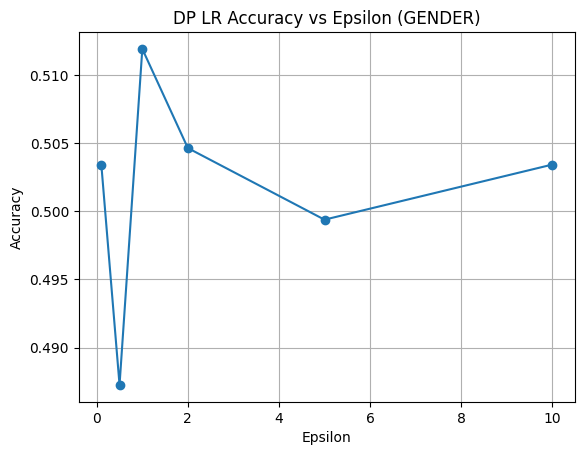

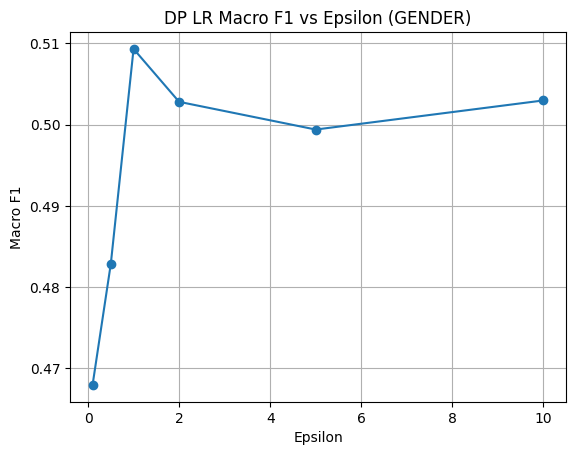

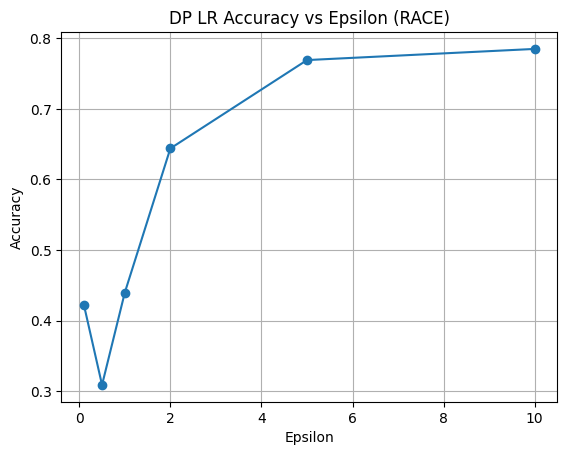

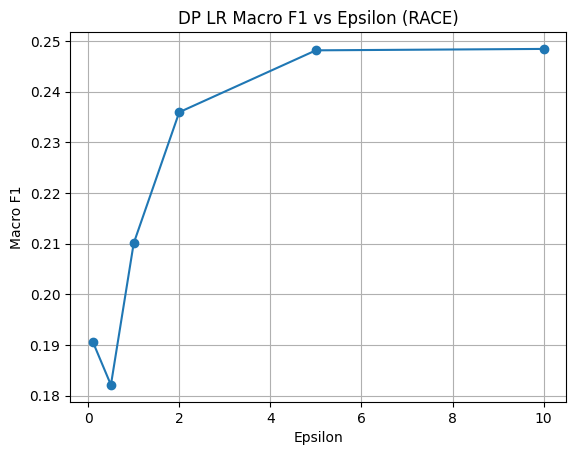

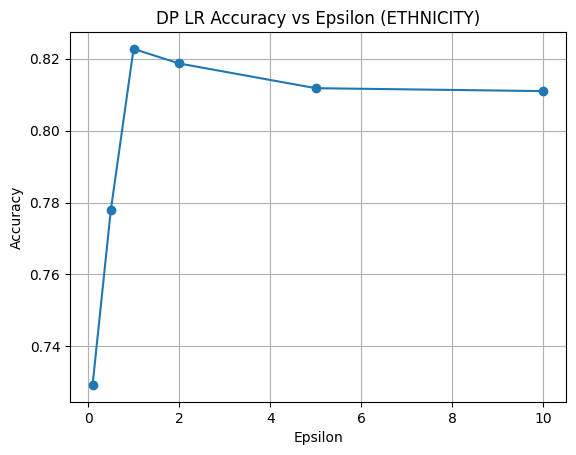

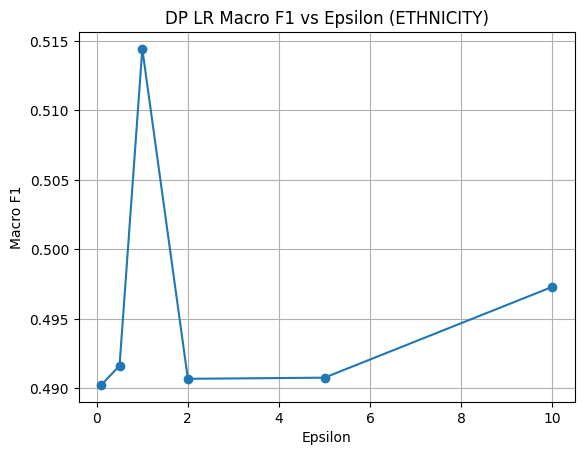

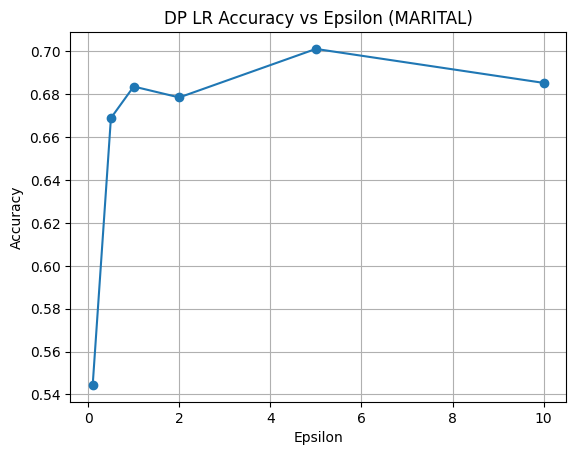

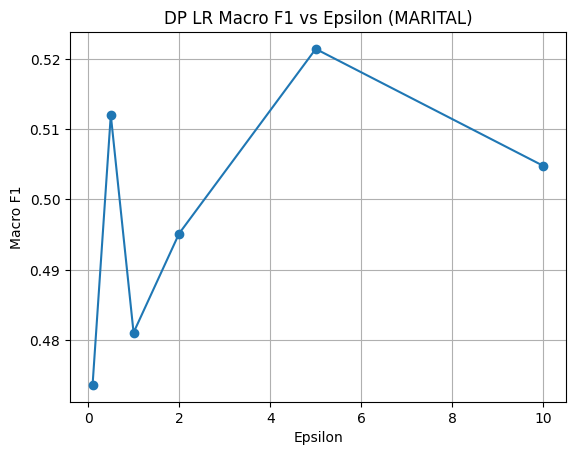

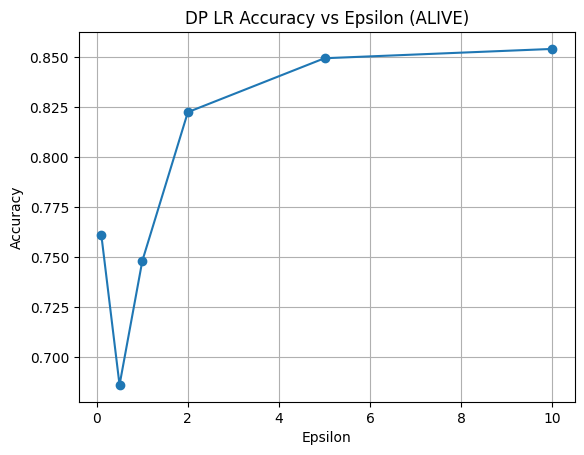

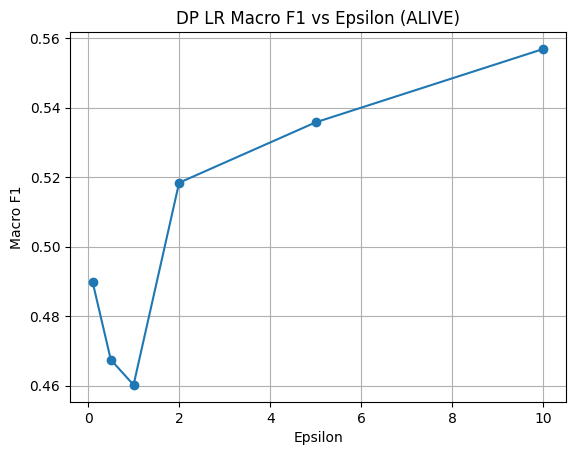

In [7]:
import matplotlib.pyplot as plt

for col in df_results["target"].unique():
    df_t = df_results[df_results["target"] == col].copy()
    df_t_eps = df_t[df_t["epsilon"] != "base"].copy()

    if df_t_eps.empty:
        continue

    plt.figure()
    plt.plot(df_t_eps["epsilon"], df_t_eps["accuracy"], marker="o")
    plt.title(f"DP LR Accuracy vs Epsilon ({col})")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(df_t_eps["epsilon"], df_t_eps["macro_f1"], marker="o")
    plt.title(f"DP LR Macro F1 vs Epsilon ({col})")
    plt.xlabel("Epsilon")
    plt.ylabel("Macro F1")
    plt.grid(True)
    plt.show()
